# DW motion using Spin Polarised Currents

## Libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# FIDIMAG libraries
from fidimag.micro import Sim
from fidimag.common import CuboidMesh

# The energies (we can use DMI in a future simulation)
from fidimag.micro import UniformExchange
from fidimag.micro import UniaxialAnisotropy
# from micro import DMI

In [2]:
%matplotlib inline

## Simulation Functions

We start defining functions to run the Fidimag simulations. The initial state is a rough approximation of a Domain Wall (DW):

In [3]:
mu0 = 4 * np.pi * 1e-7

# Initial State, a rough DW in a 1D chain
def init_m(pos):

    x = pos[0]

    if x < 400:
        return (1, 0, 0)
    elif 400 <= x < 500:
        return (0, 1, 1)
    else:
        return (-1, 0, 0)


The initial state will be relaxed for a specific mesh:

In [4]:
def relax_system(mesh):

    # Only relaxation
    sim = Sim(mesh, name='relax')

    # Simulation parameters
    sim.set_tols(rtol=1e-8, atol=1e-10)
    sim.alpha = 0.5
    sim.gamma = 2.211e5
    sim.Ms = 8.6e5
    sim.do_precession = False

    # The initial state passed as a function
    sim.set_m(init_m)
    # sim.set_m(np.load('m0.npy'))

    # Energies
    A = 1.3e-11
    exch = UniformExchange(A=A)
    sim.add(exch)

    anis = UniaxialAnisotropy(5e4)
    sim.add(anis)

    # dmi = DMI(D=8e-4)
    # sim.add(dmi)

    # Start relaxation and save the state in m0.npy
    sim.relax(dt=1e-14, stopping_dmdt=0.00001, max_steps=5000,
              save_m_steps=None, save_vtk_steps=None)

    np.save('m0.npy', sim.spin)

A plot of the system can be done with the following function, which shows a specific magnetisation component along the 1D chain of spins.

In [5]:
def plot_magnetisation(_list, save_file=None):
    """
    The list contain any number of list with two entries:
    the _file path and the component of the magnetisation
    in the formats:

            mx, my, mz

    e.g.
            _list = [ ['m0.npy', 'mz'], ... ]
    
    Optional:
        save_file     :: output file name in a string

    """

    plt.figure(figsize=(8, 6))

    comp = {'mx': 0, 'my': 1, 'mz': 2}

    for element in _list:
        # element[0]  --> _file
        # element[1]  --> m component: mx, my or mz
        
        # The npy files contain the spin vector components in the
        # format:
        #     [mx1, my1, mz1, mx2, my2, ... ]
        #
        # Thus we convert this to a N x 3 array and extract the
        # component specified in every list
        data = np.load(element[0])
        data.shape = (-1, 3)

        mx = data[:, comp[element[1]]]
        
        # The label is the component and the file name
        plt.plot(mx,
                 label=element[1] + ' / %s' % element[0],
                 lw=2
                 )

    plt.legend()
    # We assume the chain is in the x direction
    plt.xlabel(r'x')
    
    if save_file:
        plt.savefig(output_file)
    
    # plt.show()

The last function is the excitation with a current in the -x direction. This will cause the DW to motion, which we will plot later to observe the dynamical process. All the *npy* and *vtk* files are saved in the **\{simulation_name\}_npys** and **\{simulation_name\}_vtks** folders, respectively.

In [6]:
# This function excites the system with a
# current in the x-direction using Spin Transfer Torque
# formalism
def excite_system(mesh, time=5, snaps=501):

    # Specify the stt dynamics in the simulation
    sim = Sim(mesh, name='dyn', driver='llg_stt')
    
    # Set the simulation parameters
    sim.set_tols(rtol=1e-12, atol=1e-14)
    sim.alpha = 0.05
    sim.gamma = 2.211e5
    sim.Ms = 8.6e5

    # Load the initial state from the npy file saved
    # in the realxation
    sim.set_m(np.load('m0.npy'))

    # Add the energies
    A = 1.3e-11
    exch = UniformExchange(A=A)
    sim.add(exch)

    anis = UniaxialAnisotropy(5e4)
    sim.add(anis)

    # dmi = DMI(D=8e-4)
    # sim.add(dmi)

    # Set the current in the x direction, in A / m
    # beta is the parameter in the STT torque
    sim.jx = -1e12
    sim.beta = 1

    # The simulation will run for x ns and save
    # 'snaps' snapshots of the system in the process
    ts = np.linspace(0, time * 1e-9, snaps)

    for t in ts:
        print 'time', t
        sim.run_until(t)
        sim.save_vtk()
        sim.save_m()


## Initiate Simulation

In Fidimag, `nx`, `ny` and `nz` are the number of `dx`, `dy` and `dz` elements in the corresponding directions. The mesh is used in the previously defined functions: 

### Relaxation

In [7]:
# We will crate a mesh with 1000 elements of 2x2x2 nm
# in the x direction, and 1 along y and z
# (so we have a 1D system)
mesh = CuboidMesh(nx=1000, ny=1, nz=1,
              dx=2, dy=2, dz=2.0,
              unit_length=1e-9)

# Relax the initial state. It will save the last state
# to the m0.npy file
relax_system(mesh)

step=1, time=1e-14, max_dmdt=30397 ode_step=0
step=2, time=2e-14, max_dmdt=30234.9 ode_step=2.41132e-15
step=3, time=3e-14, max_dmdt=30070.2 ode_step=5.41005e-15
step=4, time=4e-14, max_dmdt=29903.1 ode_step=9.49872e-15
step=5, time=5e-14, max_dmdt=29733.7 ode_step=9.49872e-15
step=6, time=6e-14, max_dmdt=29562 ode_step=9.49872e-15
step=7, time=7e-14, max_dmdt=29388.2 ode_step=9.49872e-15
step=8, time=8.63609e-14, max_dmdt=29155.9 ode_step=1.63609e-14
step=9, time=1.02722e-13, max_dmdt=28862.9 ode_step=1.63609e-14
step=10, time=1.19083e-13, max_dmdt=28565 ode_step=1.63609e-14
step=11, time=1.35444e-13, max_dmdt=28262.6 ode_step=1.63609e-14
step=12, time=1.51804e-13, max_dmdt=27956.1 ode_step=1.63609e-14
step=13, time=1.68165e-13, max_dmdt=27645.7 ode_step=1.63609e-14
step=14, time=1.97464e-13, max_dmdt=27206.7 ode_step=2.92981e-14
step=15, time=2.26762e-13, max_dmdt=26635.3 ode_step=2.92981e-14
step=16, time=2.5606e-13, max_dmdt=26056.4 ode_step=2.92981e-14
step=17, time=2.85358e-13, m

Plot the initial State mx component. Uncomment the file name to save the figure

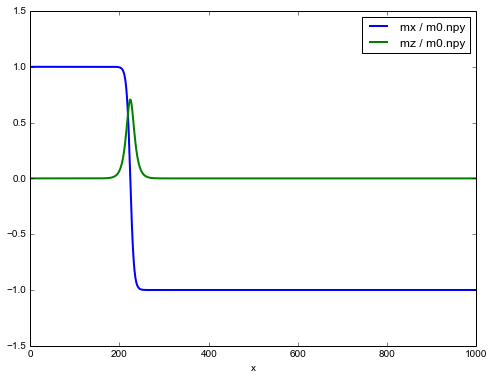

In [8]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
plot_magnetisation([['m0.npy', 'mx'], ['m0.npy', 'mz']], 
          # save_file='initial_state.pdf'
          )

The DW is at the maximum value of $|m_z|$ or $|m_y|$, and $x$ goes from 0 to 1000 nm, with one spin every 1 nm. If we use the $z$ component:

In [9]:
m0_z = np.load('m0.npy').reshape(-1, 3)[:, 2]
x = np.arange(len(m0_z))
index_max = np.argmax(np.abs(m0_z))

print 'Maximum |m_z| at x =', x[index_max]

Maximum |m_z| at x = 225


The value of $m_z$ at that point is:

In [10]:
print 'm_z (DW position) = ', m0_z[index_max]

m_z (DW position) =  0.705740362679


And we check that $m_x$ changes sign around there:

In [11]:
m0_x = np.load('m0.npy').reshape(-1, 3)[:, 0]
print 'm_x (x = %d) = ' % index_max, m0_x[index_max]
print 'm_x (x = %d) = ' % (index_max + 1), m0_x[index_max + 1]

m_x (x = 225) =  -0.0621375970771
m_x (x = 226) =  -0.184508227976


### STT

Now we excite the system with the current for 1.5 ns

In [12]:
excite_system(mesh, 1.5, 151)

time 0.0
time 1e-11
time 2e-11
time 3e-11
time 4e-11
time 5e-11
time 6e-11
time 7e-11
time 8e-11
time 9e-11
time 1e-10
time 1.1e-10
time 1.2e-10
time 1.3e-10
time 1.4e-10
time 1.5e-10
time 1.6e-10
time 1.7e-10
time 1.8e-10
time 1.9e-10
time 2e-10
time 2.1e-10
time 2.2e-10
time 2.3e-10
time 2.4e-10
time 2.5e-10
time 2.6e-10
time 2.7e-10
time 2.8e-10
time 2.9e-10
time 3e-10
time 3.1e-10
time 3.2e-10
time 3.3e-10
time 3.4e-10
time 3.5e-10
time 3.6e-10
time 3.7e-10
time 3.8e-10
time 3.9e-10
time 4e-10
time 4.1e-10
time 4.2e-10
time 4.3e-10
time 4.4e-10
time 4.5e-10
time 4.6e-10
time 4.7e-10
time 4.8e-10
time 4.9e-10
time 5e-10
time 5.1e-10
time 5.2e-10
time 5.3e-10
time 5.4e-10
time 5.5e-10
time 5.6e-10
time 5.7e-10
time 5.8e-10
time 5.9e-10
time 6e-10
time 6.1e-10
time 6.2e-10
time 6.3e-10
time 6.4e-10
time 6.5e-10
time 6.6e-10
time 6.7e-10
time 6.8e-10
time 6.9e-10
time 7e-10
time 7.1e-10
time 7.2e-10
time 7.3e-10
time 7.4e-10
time 7.5e-10
time 7.6e-10
time 7.7e-10
time 7.8e-10
time 7.9e

We plot once again to compare the initial state with the ones excited by the STT

(0, 400)

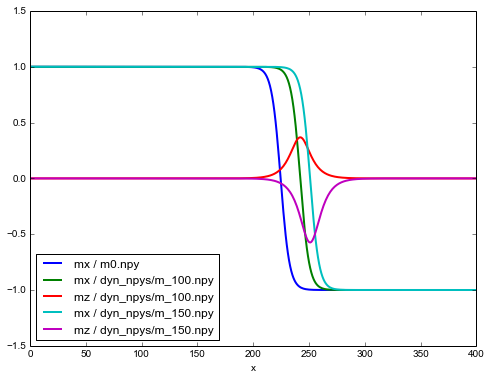

In [13]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
# We can plot the m_x component for a number snapshots
# to observe the DW motion
# We will plot the 100th and 150th files (we can also compute
# until the system reaches ~5 ns to improve the effect)
plot_magnetisation([['m0.npy', 'mx'],
                    ['dyn_npys/m_100.npy', 'mx'],
                    ['dyn_npys/m_100.npy', 'mz'],
                    ['dyn_npys/m_150.npy', 'mx'],
                    ['dyn_npys/m_150.npy', 'mz'],
                    # ['dyn_npys/m_499.npy', 'mx'],
                    # ['dyn_npys/m_499.npy', 'mz']
                    ],
                   # save_file='dw_motion_stt.pdf'
                   )
plt.legend(loc='lower left')
plt.xlim([0, 400])

We can test the DW position of these systems:

In [14]:
m0_z = np.load('dyn_npys/m_100.npy').reshape(-1, 3)[:, 2]
x = np.arange(len(m0_z))

print 'Maximum |m_z| in the 100th snapshot, at x =', x[np.argmax(np.abs(m0_z))]

Maximum |m_z| in the 100th snapshot, at x = 242


In [15]:
m0_z = np.load('dyn_npys/m_150.npy').reshape(-1, 3)[:, 2]

print 'Maximum |m_z| in the 150th snapshot, at x =', x[np.argmax(np.abs(m0_z))]

Maximum |m_z| in the 150th snapshot, at x = 251
